# Анализ удовлетворенности клиентов. Исследование комфорта при работе климатического оборудования.

## Описание проекта

### Поставленная задача

Проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах?

### Описание данных

**Год** - Год проведения исследования<br>
**Время года** - Весна, лето, осень, зима<br>
**Климат** - Название типа климата<br> 
**Город** - Город, где было проведено исследование<br> 
**Страна** - Страна, где было проведено исследование<br>
**Способ охлаждения**:<br>
- **Кондиционирование** = может быть разных типов, окна закрыты.
- **Вентиляция** = механические системы вентиляции и естественное охлаждение.
- **Смешанный** = механическое охлаждение, окна могут быть как открыты, так и закрыты.
- **NA** = не применимо, например исследование холодной зимой, когда включено отопление.
  
**Режим при смешанном типе охлаждения**:<br>
- **NA** = здания, не относящиеся к смешанному типу.
- **Кондиционер** = кондиционер включен, окна закрыты.
- **Вентиляция** = кондиционер выключен, окна открыты/механическая
	вентиляция.

**Способ обогрева**:
- **Механическое отопление** = в здании имеется механическая система отопления (переносные обогреватели не считаются механическим отоплением на уровне здания).
- **NA** = отсутствие механического отопления, неизвестно или исследование только в жаркую летнюю погоду.
  
**Возраст** - Возраст респондента<br>
**Пол** - Пол респондента<br> 
**Ощущение температуры** - Оценка температуры по ощущениям: от -3 (холодно) до +3 (горячо)<br>
**Ощущение температуры (bool)** - 0 = неприемлемо, 1 = приемлемо<br> 
**Предпочтительное изменение температуры** - Без изменений, теплее, холоднее<br> 
**Ощущение движения воздуха (bool)** - 0 = неприемлемо, 1 = приемлемо <br>
**Предпочтительное изменение движения воздуха** - Меньше, без изменений, больше<br> 
**Оценка комфорта** - От 1 (очень неудобно) до 6 (очень комфортно) <br>
**Утепление** - Фактор связанный с одеждой респондента<br> 
**Температура воздуха в помещении** - Измеренная температура в помещении<br> 
**Температура воздуха на улице** - Измеренная температура на улице <br>
**RH** - Относительная влажность <br>
**Скорость воздуха** - Скорость воздуха, м/с<br> 
**Рост** - Рост респондента<br>
**Вес** - Вес респондента <br>
**Занавески** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Вентилятор** - Режим вентилятора: 0 = выключен, 1 = включен; если неизвестно - нет данных<br> 
**Окно** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Двери** - 0 = открыты, 1 = закрыты; если неизвестно - нет данных<br>
**Отопление** - Режим обогрева: 0 -выключен, 1 - включен; если неизвестно - нет данных<br> 
**Среднемесячная температура на улице** - Среднемесячная температура наружного воздуха на момент исследования, C.<br>
**Количество рекламаций** - Количество жалоб на установленное оборудование, полученных от клиента, за прошедший период<br>

## Imports

### Скачивание библиотек

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Подключение библиотек

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu, ttest_ind, shapiro, kruskal, f_oneway
from statsmodels.stats.multitest import multipletests

## Path

In [8]:
MAIN_TABLE = 'data.csv'

## User functions

In [9]:
class SeparatorError(Exception):
    pass

# чтение файла и работа над форматом PEP8 для названий столбцов
def read_file(PATH):
    encodes = ['utf-8', 'cp1251']
    separators = [';', ',']
    dcml = '.'
    data = pd.DataFrame()
    for encode in encodes:
        for separator in separators:
            try:
                data = pd.read_csv(PATH, sep=separator, encoding=encode, decimal=dcml)
                data.columns = data.columns.str.lower().str.replace(' ', '_')
                if len(data.columns) == 1:
                    raise SeparatorError
                return data
            except UnicodeError:
                data = pd.DataFrame({'error': ['encoding']})
            except SeparatorError:
                data = pd.DataFrame({'error': ['separator']})
            except FileNotFoundError:
                data = pd.DataFrame({'error': ['file_path']})
    return data

In [10]:
# смена типа данных в столбцах(columns - словарь(key=название столбца, value - новый тип данных))
def change_types(data, columns):
    for key, val in columns.items():
        try:
            data[key] = data[key].astype(val)
        except ValueError:
            print('Ошибка при изменении типа данных в столбце с именем ', key)
        except KeyError:
            print('Возможно было неправильно указано название столбца', key)

In [11]:
# вывод уникальных значений по столбцам
def unique_values(data, columns):
    print('###########')
    print(*['\n###########\n'.join([column, '\n'.join(data[column].unique())]) for column in columns], sep='\n\n###########\n')

In [12]:
# расчет корреляции между категориальном и количественным столбцом.
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup - np.mean(subgroup)) ** 2)
        ssb += len(subgroup) * (np.mean(subgroup) - np.mean(values)) ** 2
    if ssb + ssw == 0:
        return np.nan
    return (ssb / (ssb + ssw)) ** 0.5

In [13]:
# расчет корреляции между категориальном и категориальным столбцом.
def my_cramers(x, y):
    data = pd.crosstab(x, y)
    n = data.sum().sum()
    theory = np.outer(data.values.sum(axis=1),
                      data.values.sum(axis=0)) / n
    chi2 = ((data.values - theory) ** 2 / theory).sum()
    chi2 = chi2_contingency(data)[0]
    r, c = data.values.shape
    if min(r - 1, c - 1) == 0:
        cramer = 0
    else:
        cramer = np.sqrt(chi2 / (n * min(r - 1, c - 1)))
    return cramer

In [14]:
# columns - список названий столбцов, по которым будем строить ящик с усами.
def boxplot_chart(data, columns):
    for column in columns:
        sns.boxplot(data, y=column)
        plt.title(f'График ящик с усами для столбца {column}', loc='center')
        plt.show()       

In [15]:
def addnew_col_for_pie(new_col, col, val0, val1, valnan):
    df[new_col] = df[col].replace({0: val0, 1: val1, np.nan: valnan})

In [16]:
def check_data(data_df):
  '''Функция для вывода общих сведений о датафрейме'''
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  plt.figure(figsize=(10, 6))
  sns.heatmap(df.isna().T);
  plt.suptitle('Оценка пропусков на heatmap')
  plt.show()
  print()
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление количественных данных:' + '\033[0m')
  for numeric_column in data_df.select_dtypes(exclude=['object', 'category']).columns:
    sns.histplot(data_df[numeric_column])
    plt.suptitle(f'гистограмма распределения ({numeric_column})')
    plt.show()
    print()

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление категориальных данных:' + '\033[0m')
  for categoty_column in data_df.select_dtypes(include=['object', 'category']).columns:
    table = data_df[categoty_column].value_counts().reset_index()
    table.columns = ['col1', 'count']
    plt.pie(table['count'], labels=table['col1'], autopct='%1.1f%%')
    plt.suptitle(f'Круговая диаграмма распределения ({numeric_column})')
    plt.show()
    print()

In [17]:
# Категоризация категориальных факторов методом OneHotEncoder.
# ohe = OneHotEncoder(sparse_output=False, drop='first')


# def get_ohe(train, categ):
#     temp_df = pd.DataFrame(data=ohe.transform(train[categ]), columns=ohe.get_feature_names_out())
#     data = pd.concat([train.reset_index(drop=True), temp_df], axis=1)
#     data = data.drop(columns=categ, axis=1)
#     return data

## Preproccesing

### Первичное исследование данных

Чтение данных из файла и приведение названия столбцов в соответствии с PEP8.

In [18]:
df = read_file(MAIN_TABLE)
df.sample(10)

,год,время_года,климат,город,страна,оценка_комфорта,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
96,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,NaN,Смешанный,Кондиционирование,Механическое отопление,25.0,...,0.09,NaN,NaN,NaN,NaN,0.0,0.0,NaN,22.0,0
53,2011.0,Лето,Cубтропический океанический,Техас,США,6.0,Кондиционирование,NaN,NaN,34.0,...,26.49,NaN,NaN,0.0,0.0,NaN,NaN,NaN,28.9,0
258,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,NaN,Смешанный,Кондиционирование,Механическое отопление,35.0,...,0.08,NaN,NaN,NaN,NaN,0.0,0.0,NaN,22.0,0
376,2012.0,Лето,Тропическая влажная саванна,Ченнай,Индия,6.0,Кондиционирование,NaN,NaN,25.0,...,0.34,152.4,50.0,NaN,0.0,NaN,NaN,1.0,38.1,0
197,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,NaN,Смешанный,Кондиционирование,Механическое отопление,25.0,...,0.09,NaN,NaN,NaN,NaN,0.0,0.0,NaN,22.0,0
345,2012.0,Зима,Влажный субтропический муссонный,Дели,Индия,6.0,Смешанный,Вентиляция,NaN,55.0,...,0.03,177.8,78.0,NaN,0.0,0.0,NaN,NaN,15.5,0
0,2011.0,Лето,Cубтропический океанический,Техас,США,3.5,Кондиционирование,NaN,NaN,22.0,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
387,2012.0,Лето,Тропическая влажная саванна,Ченнай,Индия,NaN,Смешанный,Кондиционирование,NaN,NaN,...,0.16,NaN,60.0,NaN,NaN,0.0,0.0,NaN,38.1,0
427,2012.0,Весна,Тропическая влажная саванна,Ченнай,Индия,NaN,Смешанный,Кондиционирование,NaN,NaN,...,0.03,NaN,63.0,NaN,NaN,0.0,0.0,NaN,30.4,0
142,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,NaN,Смешанный,Вентиляция,Механическое отопление,35.0,...,0.14,NaN,NaN,NaN,NaN,1.0,NaN,NaN,22.0,0


Проверим название столбцов

In [19]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'оценка_комфорта',
       'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения',
       'способ_обогрева', 'возраст', 'пол', 'ощущение_температуры',
       'ощущение_температуры_(bool)', 'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'утепление',
       'температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh',
       'скорость_воздуха', 'рост', 'вес', 'занавески', 'вентилятор', 'окно',
       'двери', 'отопление', 'среднемесячная_температура_на_улице',
       'количество_рекламаций'],
      dtype='object')

Уберем лишнее

In [20]:
df.columns = df.columns.str.replace('(', '').str.replace(')', '')
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'оценка_комфорта',
       'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения',
       'способ_обогрева', 'возраст', 'пол', 'ощущение_температуры',
       'ощущение_температуры_bool', 'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'утепление',
       'температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh',
       'скорость_воздуха', 'рост', 'вес', 'занавески', 'вентилятор', 'окно',
       'двери', 'отопление', 'среднемесячная_температура_на_улице',
       'количество_рекламаций'],
      dtype='object')

Выведем информацию про каждый столбец

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   оценка_комфорта                              215 non-null    float64
 6   способ_охлаждения                            484 non-null    object 
 7   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 8   способ_обогрева                              222 non-null    object 
 9   возраст                                      413 non-null    float64
 10  по

In [22]:
# заменим для удобства все 0 и 1 в занавески, вентилятор, окно, двери, отопление на да и нет
for col in ['занавески', 'окно', 'двери']:
    addnew_col_for_pie(f'{col}_кат', col, 'открыто', 'закрыто', 'не определен')

addnew_col_for_pie('вентилятор_кат', 'вентилятор', 'выключен', 'включен', 'не определен')

In [23]:
columns = {'год': int, 'возраст': float, 'ощущение_температуры': float, 'ощущение_температуры_bool': bool, 
           'ощущение_движения_воздуха_bool': bool, 'оценка_комфорта': float, 'утепление': float,
           'температура_воздуха_в_помещении': float, 'температура_воздуха_на_улице': float,
           'rh': float, 'скорость_воздуха': float, 'рост': float, 'вес': float, 'среднемесячная_температура_на_улице': float}
change_types(df, columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int64  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   оценка_комфорта                              215 non-null    float64
 6   способ_охлаждения                            484 non-null    object 
 7   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 8   способ_обогрева                              222 non-null    object 
 9   возраст                                      413 non-null    float64
 10  по

Пока не заполнили пропуски в возрасте, его преобразовывать в int нельзя. После заполнения нужно про это вспомнить и изменить.

Посмотрим описательную статистику для количественных типов данных

In [24]:
df.describe(exclude=object)

,год,оценка_комфорта,возраст,ощущение_температуры,ощущение_температуры_bool,ощущение_движения_воздуха_bool,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
count,484.000000,215.000000,413.000000,484.000000,484,484,484.000000,484.000000,72.000000,484.000000,484.000000,143.000000,214.000000,72.000000,146.000000,279.000000,157.000000,79.00000,484.000000,484.000000
unique,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,382,435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2011.033058,4.772093,40.634383,0.203306,NaN,NaN,0.634587,26.072107,24.104167,52.973760,0.760558,164.411678,65.471963,0.513889,0.527397,0.247312,0.184713,0.78481,27.389669,0.105372
std,0.922988,1.261161,11.001301,1.091976,NaN,NaN,0.253103,7.681363,0.604546,13.036204,4.921106,21.273235,11.574079,0.503315,0.500967,0.432225,0.389307,0.41358,19.469562,0.440276
min,2010.000000,1.000000,22.000000,-3.000000,NaN,NaN,0.360000,16.200000,22.800000,23.800000,0.000000,5.230000,42.000000,0.000000,0.000000,0.000000,0.000000,0.00000,8.500000,0.000000
25%,2010.000000,4.000000,35.000000,0.000000,NaN,NaN,0.460000,23.800000,23.800000,42.775000,0.060000,160.000000,57.000000,0.000000,0.000000,0.000000,0.000000,1.00000,22.000000,0.000000
50%,2011.000000,5.000000,42.000000,0.000000,NaN,NaN,0.590000,24.600000,24.100000,53.750000,0.100000,165.100000,65.000000,1.000000,1.000000,0.000000,0.000000,1.00000,22.000000,0.000000
75%,2012.000000,6.000000,45.000000,1.000000,NaN,NaN,0.700000,25.900000,24.400000,62.325000,0.140000,172.700000,72.750000,1.000000,1.000000,0.000000,0.000000,1.00000,30.800000,0.000000


### Выбросы

Посмотрим ящики с усами для всех интересующих нас количественных столбцов для выявления возможных выбросов.

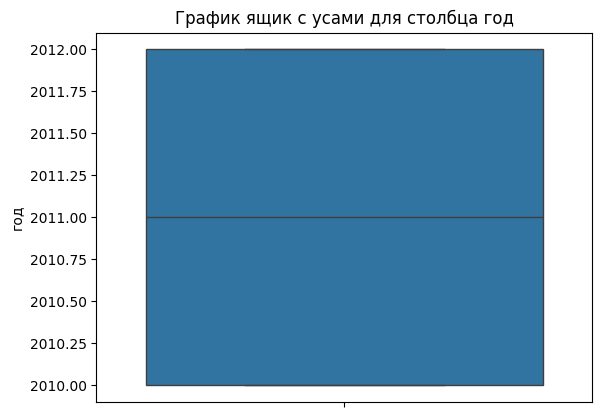

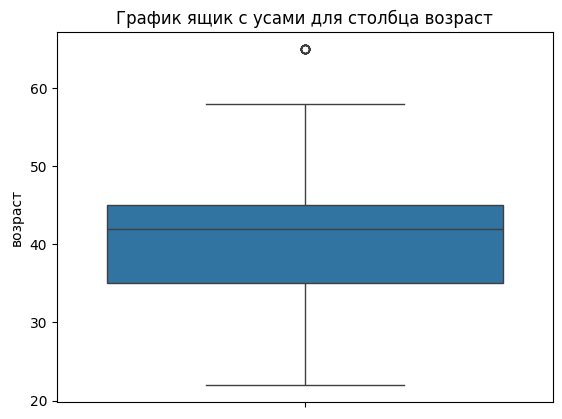

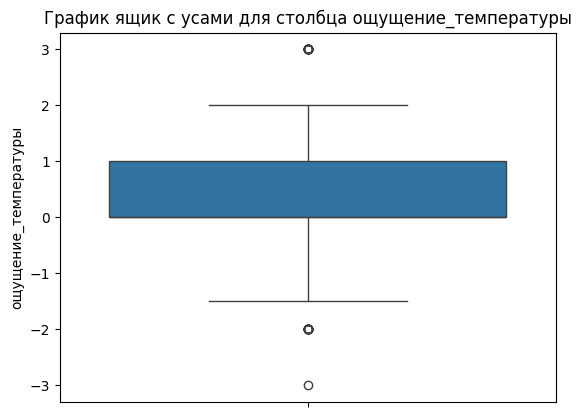

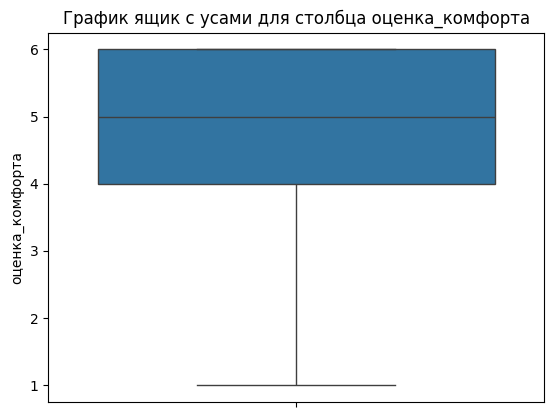

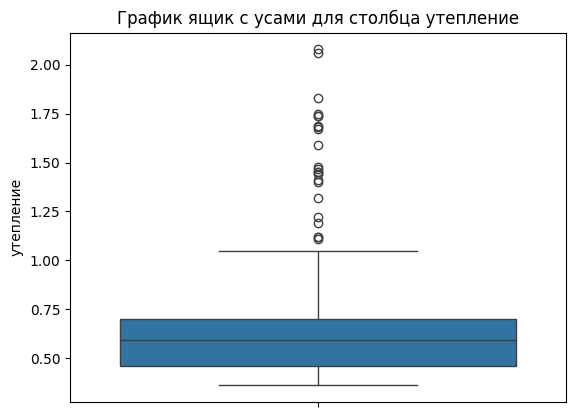

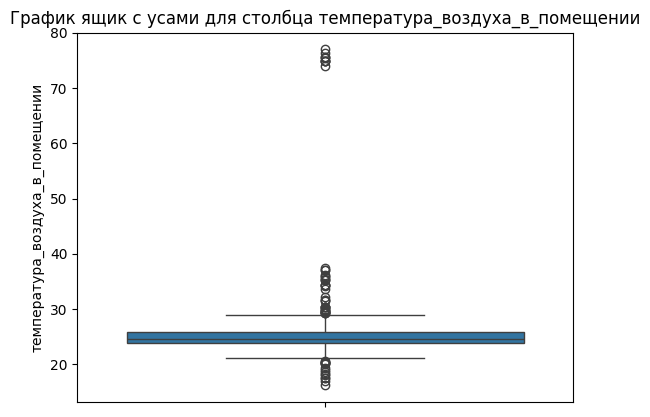

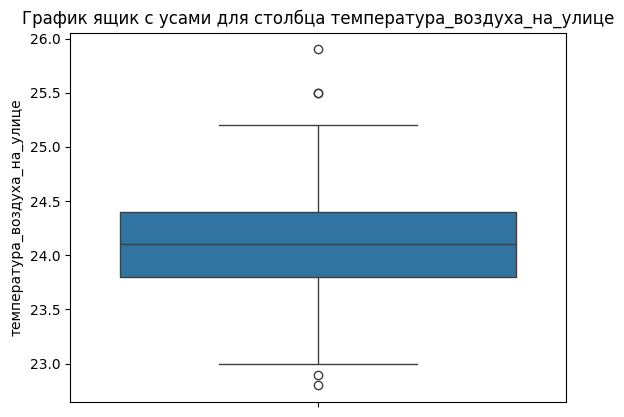

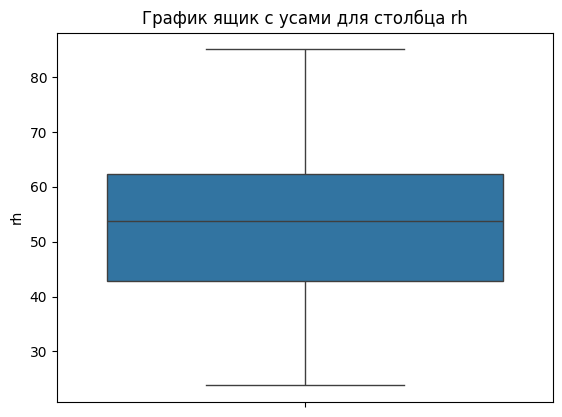

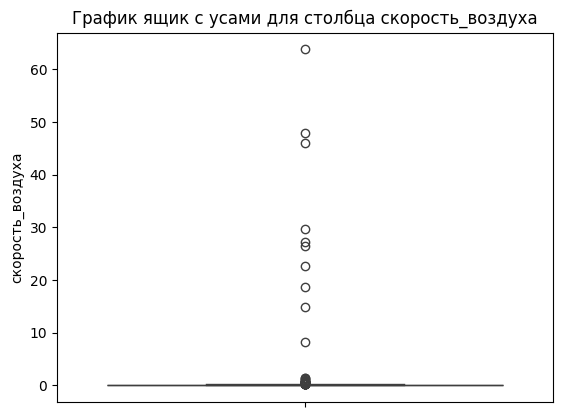

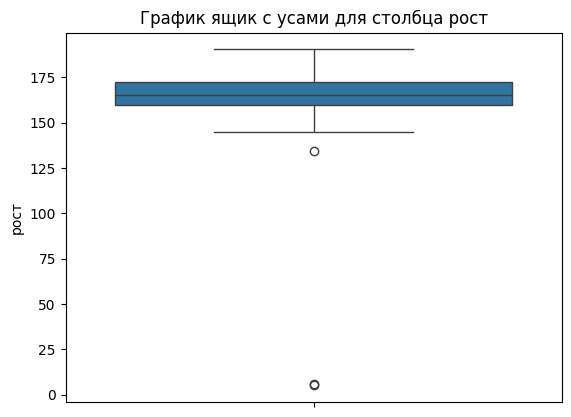

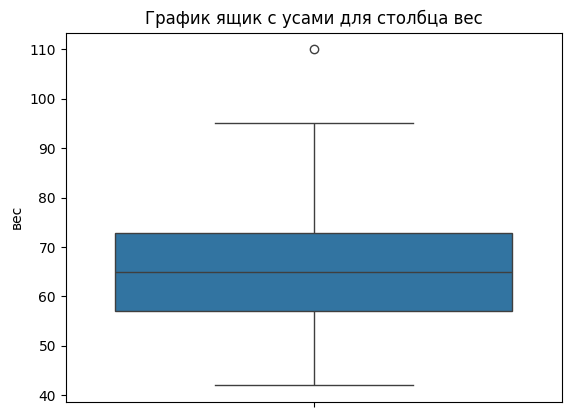

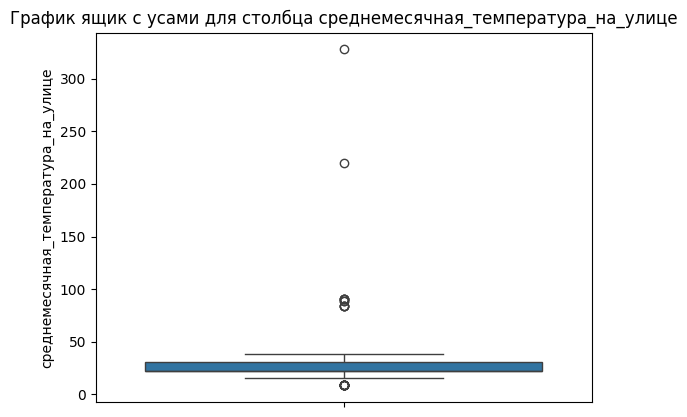

In [25]:
columns = ['год', 'возраст', 'ощущение_температуры', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении',
           'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'среднемесячная_температура_на_улице']
boxplot_chart(df, columns)

In [26]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'оценка_комфорта',
       'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения',
       'способ_обогрева', 'возраст', 'пол', 'ощущение_температуры',
       'ощущение_температуры_bool', 'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'утепление',
       'температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh',
       'скорость_воздуха', 'рост', 'вес', 'занавески', 'вентилятор', 'окно',
       'двери', 'отопление', 'среднемесячная_температура_на_улице',
       'количество_рекламаций', 'занавески_кат', 'окно_кат', 'двери_кат',
       'вентилятор_кат'],
      dtype='object')

Сделаем выводы по этим графикам: <br>
- со столбцом год все нормально.
- со столбцом возраст все нормально.
- к столбцу ощущение_температуры есть вопросы. Взглянем на строки, где встретились выбросы.
- со столбцом оценка_комфорта выбросов не наблюдаем, по значениям будет обговорено позже.
- со стобцом утепление нужно разобраться, разобьем его на группы по временам года и посмотрим график.
- со столбцом температура_воздуха_в_помещении нужно разобраться почему присутствуют выбросы. Скорее всего связано со спецификой работы.
- со столбцом температура_воздуха_на_улице все нормально.
- со столбцом rh на первый взгляд все нормально.
- к столбцу скорость_воздуха есть вопросы. Очень странные выбросы.
- к столбцу рост есть вопросы. Посмотрим почему возникли выбросы и разрешим эту проблему.
- со столбцом вес все нормально.(Не можем утверждать, что присутствуют выбросы)
- со столбцом среднемесячная_температура_на_улице проблемы. Рассмотрим строки с этими значениями более подробно.

In [27]:
df.query('ощущение_температуры < -2 | ощущение_температуры > 2')[['климат', 'время_года', 'страна', 'ощущение_температуры', 
                                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                 'среднемесячная_температура_на_улице']].sort_values(by='ощущение_температуры')

,климат,время_года,страна,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
350,Тропическая влажная саванна,Весна,Индия,-3.0,NaN,26.6,30.4
76,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.7,22.0
203,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.1,22.0
176,Cубтропический океанический,Лето,Австралия,3.0,NaN,22.9,22.0
211,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.5,22.0
222,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.4,22.0
261,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.2,22.0
208,Cубтропический океанический,Лето,Австралия,3.0,NaN,23.9,22.0
264,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.8,22.0
283,Жаркий полузасушливый,Весна,Индия,3.0,NaN,28.7,31.5


In [28]:
df['ощущение_температуры'].describe()

count    484.000000
mean       0.203306
std        1.091976
min       -3.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ощущение_температуры, dtype: float64

Однозначных выводов, как заменить выбросы в столбце ощущение_температуры нет.

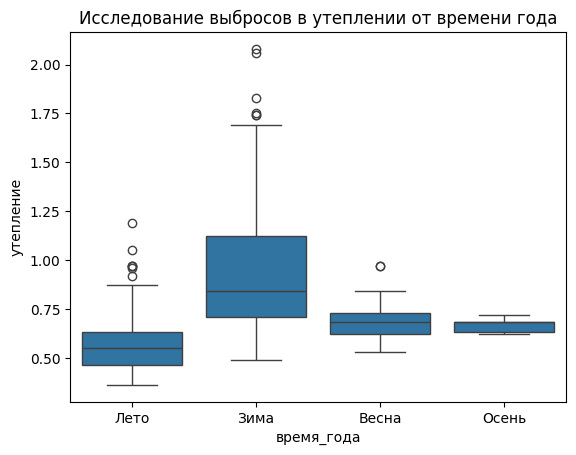

In [29]:
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

Выбросы в утеплении летом могут поломать логику нашего исследования, я хочу устранить их путем заменой на групповую медиану по времени года.

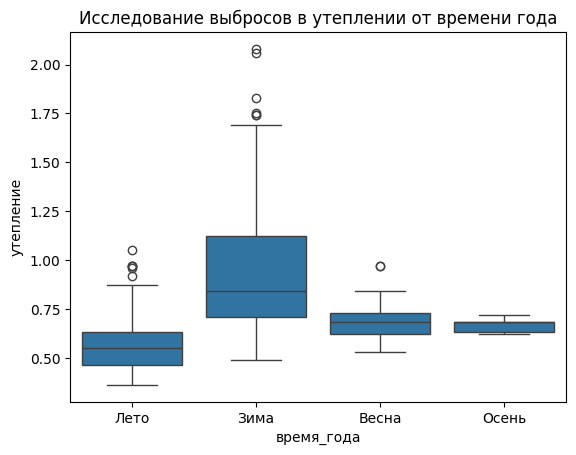

In [30]:
q1 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.25)
q3 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.75)
mask = df[(df['время_года'] == 'Лето') & (df['утепление'] > q3 + 3 * (q3 - q1))].index.to_list()
df.loc[mask, 'утепление'] = df.groupby('время_года')['утепление'].transform('median')
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

In [31]:
df.query('температура_воздуха_в_помещении > 40')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                  'среднемесячная_температура_на_улице']].sort_values(by='температура_воздуха_в_помещении')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
45,Cубтропический океанический,Лето,США,Техас,-1.0,23.3,74.0,31.7
1,Cубтропический океанический,Лето,США,Техас,-2.0,23.7,74.8,84.0
7,Cубтропический океанический,Лето,США,Техас,-2.0,23.6,74.8,32.8
33,Cубтропический океанический,Лето,США,Техас,-1.0,24.2,74.9,32.8
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,74.9,84.0
38,Cубтропический океанический,Лето,США,Техас,1.0,24.3,75.5,28.9
54,Cубтропический океанический,Лето,США,Техас,-2.0,24.1,75.7,28.9
41,Cубтропический океанический,Лето,США,Техас,0.0,24.1,75.7,31.7
9,Cубтропический океанический,Лето,США,Техас,1.0,24.4,76.4,31.7
23,Cубтропический океанический,Лето,США,Техас,1.6,24.7,77.0,32.8


У данных выбросов есть интересная схожесть - страна, где проходили исследования. США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

In [32]:
df['температура_воздуха_в_помещении'] = df['температура_воздуха_в_помещении'].apply(lambda x: x if x < 40 else ((5 / 9) * (x - 32)))
df['температура_воздуха_в_помещении'].describe()

count    484.000000
mean      25.012695
std        2.762848
min       16.200000
25%       23.800000
50%       24.600000
75%       25.700000
max       37.400000
Name: температура_воздуха_в_помещении, dtype: float64

In [33]:
df.query('скорость_воздуха > 1').describe(include=object)

,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,пол,предпочтительное_изменение_температуры,предпочтительное_изменение_движения_воздуха,занавески_кат,окно_кат,двери_кат,вентилятор_кат
count,13,13,13,13,13,2,1,3,13,13,13,13,13,13
unique,2,4,4,2,3,2,1,2,3,3,3,3,2,3
top,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Кондиционирование,Механическое отопление,Мужской,Без изменений,Без изменений,закрыто,не определен,не определен,включен
freq,12,10,10,10,10,1,1,2,9,8,5,10,12,7


In [34]:
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe())
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.000000
mean       2.820000
std        9.890699
min        0.030000
25%        0.100000
50%        0.130000
75%        0.210000
max       63.830000
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.000000
mean       0.118309
std        0.140862
min        0.000000
25%        0.060000
50%        0.090000
75%        0.120000
max        1.420000
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.000000
mean      0.204848
std       0.318474
min       0.000000
25%       0.030000
50%       0.060000
75%       0.190000
max       1.430000
Name: скорость_воздуха, dtype: float64




Заполним выбросы медианой по группе относительно способа охлаждения.

In [35]:
q1 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.25)
q3 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.75)
mask = df[(df['скорость_воздуха'] > 3 * (q3 - q1) + q3) & (df['способ_охлаждения'] == 'Кондиционирование')].index.to_list()
df.loc[mask, 'скорость_воздуха'] = df.groupby('способ_охлаждения')['скорость_воздуха'].transform('median')
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe())
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.000000
mean       0.148333
std        0.082654
min        0.030000
25%        0.100000
50%        0.130000
75%        0.170000
max        0.450000
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.000000
mean       0.118309
std        0.140862
min        0.000000
25%        0.060000
50%        0.090000
75%        0.120000
max        1.420000
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.000000
mean      0.204848
std       0.318474
min       0.000000
25%       0.030000
50%       0.060000
75%       0.190000
max       1.430000
Name: скорость_воздуха, dtype: float64




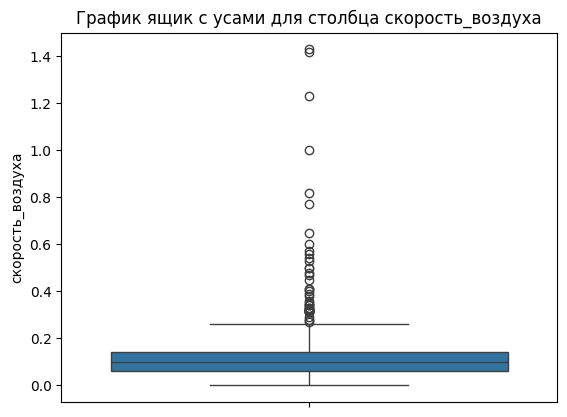

In [36]:
boxplot_chart(df, ['скорость_воздуха'])

In [37]:
df.query(f'рост < {df["рост"].quantile(0.05)}')

,год,время_года,климат,город,страна,оценка_комфорта,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,...,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат
287,2012,Зима,Влажный субтропический муссонный,Дели,Индия,5.0,Смешанный,Вентиляция,NaN,35.0,...,0.0,0.0,NaN,NaN,15.5,0,не определен,открыто,не определен,выключен
301,2012,Лето,Субтропическое высокогорье,Шимла,Индия,5.0,Смешанный,Вентиляция,Механическое отопление,55.0,...,NaN,NaN,NaN,0.0,18.5,0,не определен,не определен,не определен,не определен
306,2012,Лето,Субтропическое высокогорье,Шимла,Индия,5.0,Вентиляция,NaN,NaN,45.0,...,NaN,1.0,NaN,NaN,18.5,0,не определен,закрыто,не определен,не определен
325,2012,Зима,Жаркий полузасушливый,Ахмедабад,Индия,4.0,Вентиляция,NaN,NaN,25.0,...,0.0,0.0,NaN,NaN,21.3,0,не определен,открыто,не определен,выключен
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,4.0,Смешанный,Кондиционирование,Механическое отопление,25.0,...,NaN,0.0,NaN,NaN,8.5,0,не определен,открыто,не определен,не определен


Можем предпложить, что в Индии длина измеряется по-своему. Возможно это футы или Ilahi Gaz. Но если переводить в эти величины, то можно ужаснутся большими значениями. По тому данные значения будем считать NaN,
в заполнении пропусков будем думать, как такие значения заполнять.

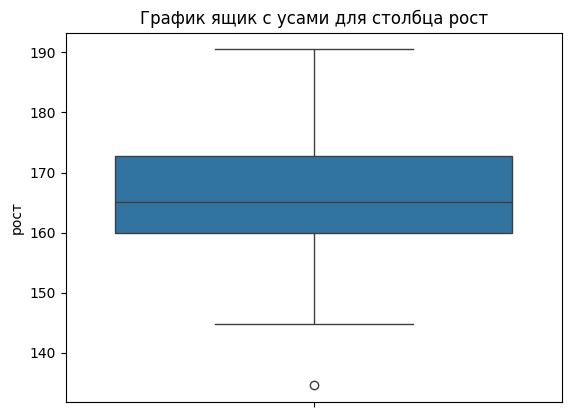

,год,время_года,климат,город,страна,оценка_комфорта,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,...,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,4.0,Смешанный,Кондиционирование,Механическое отопление,25.0,...,NaN,0.0,NaN,NaN,8.5,0,не определен,открыто,не определен,не определен


In [38]:
df['рост'] = df['рост'].apply(lambda x: np.nan if x < 10 else x)
boxplot_chart(df, ['рост'])
df.query('рост < 140')

У нас остался один предполагаемый выброс. Мы не можем его таким считать, так как это возможно особенность человека.

In [39]:
df.query(f'среднемесячная_температура_на_улице > {df["среднемесячная_температура_на_улице"].quantile(0.95)}')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                                                                               'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                                                               'среднемесячная_температура_на_улице']].sort_values(by='среднемесячная_температура_на_улице')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
1,Cубтропический океанический,Лето,США,Техас,-2.0,23.7,23.777778,84.0
14,Cубтропический океанический,Лето,США,Техас,-1.5,23.0,23.200000,84.0
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,23.833333,84.0
44,Cубтропический океанический,Лето,США,Техас,-2.0,23.9,24.000000,84.0
34,Cубтропический океанический,Лето,США,Техас,2.0,24.1,24.300000,89.0
39,Cубтропический океанический,Лето,США,Техас,2.0,24.4,24.400000,89.0
30,Cубтропический океанический,Лето,США,Техас,-1.3,24.2,24.300000,91.0
20,Cубтропический океанический,Лето,США,Техас,0.0,23.6,23.600000,91.0
68,Cубтропический океанический,Лето,США,Техас,1.5,25.9,26.000000,91.0
28,Cубтропический океанический,Лето,США,Техас,-0.5,24.6,23.900000,91.0


США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

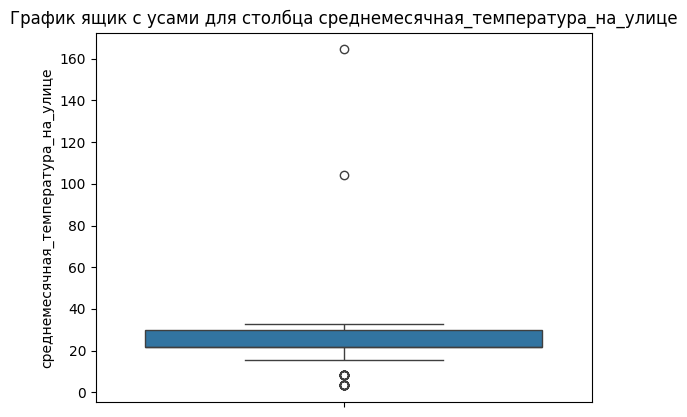

In [40]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < df["среднемесячная_температура_на_улице"].quantile(0.95) else ((5 / 9) * (x - 32)))
df['среднемесячная_температура_на_улице'].describe()
boxplot_chart(df, ['среднемесячная_температура_на_улице'])

Оставшиеся выбросы заменим на NaN для последующей замены на этапе заполнения пропусков

In [41]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < 100 else np.nan)
df['среднемесячная_температура_на_улице'].describe()

count    482.000000
mean      24.035731
std        6.630709
min        3.388889
25%       22.000000
50%       22.000000
75%       29.900000
max       32.800000
Name: среднемесячная_температура_на_улице, dtype: float64

### Дубликаты

Выявим и заменим неявные дубликаты

In [42]:
duplicates = df[df.duplicated()]
duplicates

,год,время_года,климат,город,страна,оценка_комфорта,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,...,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат
482,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,NaN,Смешанный,Кондиционирование,NaN,NaN,...,NaN,0.0,0.0,NaN,21.6,0,не определен,открыто,открыто,не определен
483,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,NaN,Смешанный,Кондиционирование,NaN,NaN,...,NaN,0.0,0.0,NaN,21.6,0,не определен,открыто,открыто,не определен


In [43]:
df = df.drop_duplicates()

In [44]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, df[i].unique())

время_года ['Лето' 'Зима' 'Весна' 'Осень']
климат ['Cубтропический океанический' 'Cубтроп океанич'
 'Субтропическое высокогорье' 'Жаркий полузасушливый'
 'Тропическая влажная саванна' 'Влажный субтропический муссонный']
город ['Техас' 'Сидней' 'Шимла' 'Хайдарабад' 'Бангалор' 'Ахмедабад' 'Ченнай'
 'Дели']
страна ['США' 'Австралия' 'Индия']
способ_охлаждения ['Кондиционирование' 'Смешанный' 'Вентиляция']
режим_при_смешанном_типе_охлаждения [nan 'Кондиционирование' 'Вентиляция']
способ_обогрева [nan 'Механическое отопление']
пол [nan 'Женский' 'Мужской']
предпочтительное_изменение_температуры ['Без изменений' 'Теплее' 'Холоднее' 'Холодн' 'Тепле']
предпочтительное_изменение_движения_воздуха ['Без изменений' 'Меньше' 'Больше']
занавески_кат ['закрыто' 'открыто' 'не определен']
окно_кат ['не определен' 'закрыто' 'открыто']
двери_кат ['не определен' 'открыто' 'закрыто']
вентилятор_кат ['включен' 'выключен' 'не определен']


Заменим опечатки на правильные значения

In [45]:
df['климат'] = df['климат'].map({'Cубтроп океанич': 'Субтропический океанический',
                                 'Cубтропический океанический': 'Субтропический океанический'
                                }).fillna(df['климат'])

In [46]:
df['климат'].unique()

array(['Субтропический океанический', 'Субтропическое высокогорье',
       'Жаркий полузасушливый', 'Тропическая влажная саванна',
       'Влажный субтропический муссонный'], dtype=object)

In [47]:
df['предпочтительное_изменение_температуры'] = df['предпочтительное_изменение_температуры'].map({'Холодн': 'Холоднее',
                                                                                                'Тепле': 'Теплее'}).fillna(df['предпочтительное_изменение_температуры'])


In [48]:
df['предпочтительное_изменение_температуры'].unique()

array(['Без изменений', 'Теплее', 'Холоднее'], dtype=object)

### Пропуски

In [49]:
# Заполнение пропусков 
""" Оно требуется в столбцах возраст ( 71 пропуск ), пол ( 72 пропуска ), 
                             рост ( 341 пропуск ) , вес ( 270 пропусков )  оценка_комфорта ( 269 пропусков ),
                             отопление, окно, дверь, вентилятор, занавески, отопление"""

# В других столбцах где присутствуют пропуски заполнение точно не требуется

# для начали проанализируем данные столбцы по странам
for col in ['возраст', 'пол', 'рост', 'вес', 'оценка_комфорта', 'отопление']:
    print(col)
    print()
    for cntr in df['страна'].unique():
        print(cntr.ljust(8), '\t', 
              'Кол-во не пустых значений:', str(df[(df['страна'] == cntr) & (df[col].notna())].shape[0]).ljust(3), '\t',
              'Кол-во Nan:', df[(df['страна'] == cntr) & (df[col].isna())].shape[0])
    print()

возраст

США      	 Кол-во не пустых значений: 72  	 Кол-во Nan: 0
Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 0
Индия    	 Кол-во не пустых значений: 143 	 Кол-во Nan: 69

пол

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 0
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

рост

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
Индия    	 Кол-во не пустых значений: 141 	 Кол-во Nan: 71

вес

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

оценка_комфорта

США      	 Кол-во не пустых значений: 72  	 Кол-во Nan: 0
Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
Индия    	 Кол-во не пустых значений: 143 	 Кол-во Nan: 69

отопление

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan:

In [50]:
# Заметим, что пустые значения только у страны США, в других заполненны, так что просто оставим np.nan

# Возраст — медиана по полу и по странам (можно заметить что все 71 пропуск из страны Индии"""
df['возраст'] = df.groupby(['пол', 'страна'])['возраст'].transform(lambda x: x.fillna(x.median()))

# Рост - заметим что у страны США и Австралия не заполненно, так что оставим как np.nan
# А вот у Индии заполним по полу средним значением
mn_india_hght = df[df['страна'] == 'Индия'].groupby('пол')['рост'].mean()

df['рост'] = df.apply(
    lambda x: (mn_india_hght[x['пол']] if pd.isna(x['рост']) and x['страна'] == 'Индия'
               else (np.nan if pd.isna(x['рост']) else x['рост'])), axis=1)

# Видим, что у столбца вес страны США и Австралии отсутвуют заполненные значения, так что их оставим пустыми

# Видим, что у оценки комфорта аналогичная ситуация как и у роста, однако заполненны значения у страны США
# У Индии заполним по времени года и способу охдаждения средним значением, у страны Австралия оставим np.nan
mn_india_cmfrt = df[df['страна'] == 'Индия'].groupby(['время_года', 'способ_охлаждения'])['оценка_комфорта'].mean()
df['оценка_комфорта'] = df.apply(lambda x: (
        mn_india_cmfrt.get((x['время_года'], x['способ_охлаждения']), x['оценка_комфорта'])
        if pd.isna(x['оценка_комфорта']) and x['страна'] == 'Индия'
        else x['оценка_комфорта']), axis=1)

# Также заполним пропуски 'среднемесячная_температура_на_улице' после удаления выбросов - средним по климату
df['среднемесячная_температура_на_улице'] = df.groupby('климат')['среднемесячная_температура_на_улице'].transform(
    lambda x: x.fillna(x.mean()))

In [51]:
# пропуски в отоплении
# cоздадим разные датасеты для стран
# будем заполнять отопление исходя из температуры на улице и в помещении по каждой стране
df_au = df[df['страна'] == 'Австралия'].copy()
df_us = df[df['страна'] == 'США'].copy()
df_in = df[df['страна'] == 'Индия'].copy()

target = 'отопление'

### Австралия

In [52]:
df_au[target].isna().mean()

np.float64(1.0)

In [53]:
df_au[['город', 'климат']].value_counts(normalize=True).to_frame()

,,proportion
город,климат,
Сидней,Субтропический океанический,1.0


In [54]:
df_au.groupby(['время_года', target], dropna=False).size().to_frame()

,,0
время_года,отопление,
Лето,NaN,198


In [55]:
# узнаем какая средняя температура на улице и в помещении
df_au['среднемесячная_температура_на_улице'].median()

np.float64(22.0)

In [56]:
df_au['температура_воздуха_в_помещении'].median()

np.float64(24.3)

In [57]:
# температура на улице схожа с температурой в помещении да и в целом кто врубит батарею в 20 градусов, => отопление=0
df_au[target] = df_au[target].fillna(0)

### США

In [58]:
df_us[target].isna().mean()

np.float64(1.0)

In [59]:
df_us[['город', 'климат']].value_counts(normalize=True).to_frame()

,,proportion
город,климат,
Техас,Субтропический океанический,1.0


In [60]:
df_us.groupby(['время_года', target], dropna=False).size().to_frame()

,,0
время_года,отопление,
Лето,NaN,72


In [61]:
# узнаем какая средняя температура на улице и в помещении
df_us['среднемесячная_температура_на_улице'].median()

np.float64(31.7)

In [62]:
df_us['температура_воздуха_в_помещении'].median()

np.float64(24.1)

In [63]:
# температура на улице в среднем 30 градусов а в помещении 24, вряд ли кто то будет включать отопление в +30 => отопление=0
df_us[target] = df_us[target].fillna(0)

### Индия

In [64]:
df_in[target].isna().mean() # 60 процентов информации отсутствует

np.float64(0.6273584905660378)

In [65]:
df_in.groupby(['время_года', target], dropna=False).size().to_frame()

0
время_года отопление    
Весна      NaN        18
Зима       0.0         6
           1.0        19
           NaN        54
Лето       0.0        11
           1.0        43
           NaN        48
Осень      NaN        13

In [66]:
df_in[['город', 'климат']].value_counts(normalize=True)

город       климат                          
Ченнай      Тропическая влажная саванна         0.240566
Ахмедабад   Жаркий полузасушливый               0.179245
Дели        Влажный субтропический муссонный    0.165094
Шимла       Субтропическое высокогорье          0.150943
Хайдарабад  Жаркий полузасушливый               0.141509
Бангалор    Тропическая влажная саванна         0.122642
Name: proportion, dtype: float64

In [67]:
df_in.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
})

среднемесячная_температура_на_улице  \
время_года климат                           отопление                                        
Весна      Жаркий полузасушливый            NaN                                  31.500000   
           Тропическая влажная саванна      NaN                                  30.400000   
Зима       Влажный субтропический муссонный 0.0                                  15.500000   
                                            1.0                                  15.500000   
                                            NaN                                  15.500000   
           Жаркий полузасушливый            0.0                                  21.300000   
                                            1.0                                  21.300000   
                                            NaN                                  21.600000   
           Субтропическое высокогорье       NaN                                   8.500000   
           Тропическая влажная саванна      0.0                                  29.900000   
                                            1.0                                  29.900000   
                                            NaN                                  30.800000   
Лето       Влажный субтропический муссонный 0.0                                  30.900000   
                                            1.0                                  30.900000   
                                            NaN                                  30.900000   
           Жаркий полузасушливый            0.0                                  29.500000   
                                            1.0                                  29.500000   
                                            NaN                                  29.500000   
           Субтропическое высокогорье       0.0                                  18.500000   
                                            NaN                                  18.500000   
           Тропическая влажная саванна      0.0                                  17.094444   
                                            1.0                                  30.800000   
                                            NaN                                   3.388889   
Осень      Жаркий полузасушливый            NaN                                  25.700000   
           Тропическая влажная саванна      NaN                                  29.700000   

                                                       температура_воздуха_в_помещении  \
время_года климат                           отопление                                    
Весна      Жаркий полузасушливый            NaN                                  27.90   
           Тропическая влажная саванна      NaN                                  26.60   
Зима       Влажный субтропический муссонный 0.0                                  25.30   
                                            1.0                                  23.80   
                                            NaN                                  18.30   
           Жаркий полузасушливый            0.0                                  26.85   
                                            1.0                                  25.30   
                                            NaN                                  27.20   
           Субтропическое высокогорье       NaN                                  20.20   
           Тропическая влажная саванна      0.0                                  28.05   
                                            1.0                                  25.90   
                                            NaN                                  26.60   
Лето       Влажный субтропический муссонный 0.0                                  34.60   
                                            1.0                                  24.40   
                                            NaN                             

In [68]:
# основываясь на данных из таблицы вручную проставим значения отопления для каждого сезона и климата

# весна
df_in.loc[(df_in['время_года'] == 'Весна'), target] = 0

# зима
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Влажный субтропический муссонный') & (df_in[target].isnull()), target] = 1
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Жаркий полузасушливый') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Субтропическое высокогорье') & (df_in[target].isnull()), target] = 1
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Тропическая влажная саванна') & (df_in[target].isnull()), target] = 0

# лето
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Влажный субтропический муссонный') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Жаркий полузасушливый') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Субтропическое высокогорье') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Тропическая влажная саванна'), target] = 1

# осень
df_in.loc[(df_in['время_года'] == 'Осень'), target] = 0

In [69]:
df = pd.concat([df_au, df_us, df_in])

In [70]:
df.isna().sum()

год                                              0
время_года                                       0
климат                                           0
город                                            0
страна                                           0
оценка_комфорта                                229
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения            147
способ_обогрева                                260
возраст                                         72
пол                                             72
ощущение_температуры                             0
ощущение_температуры_bool                        0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_bool                   0
предпочтительное_изменение_движения_воздуха      0
утепление                                        0
температура_воздуха_в_помещении                  0
температура_воздуха_на_улице                   410
rh                             

Мы оставили только те пропуски, которые заменять не стоит в условиях интересующей нас задачи.

для удобного просмотра перевед столбец отопление в категориальный

In [71]:
addnew_col_for_pie('отопление_кат', 'отопление', 'выключен', 'включен', 'не определен')

## EDA

### Просмотр данных

Количественные данные мы посмотрели, теперь взглянем на распределение категориальных данных

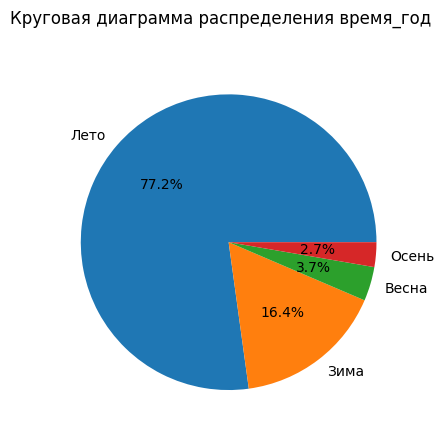

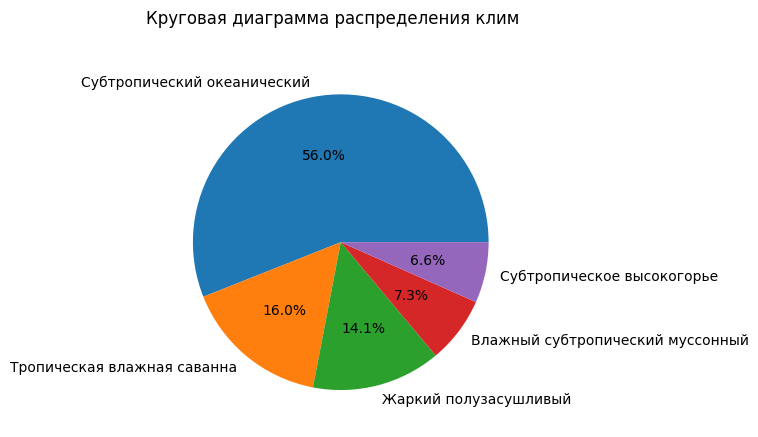

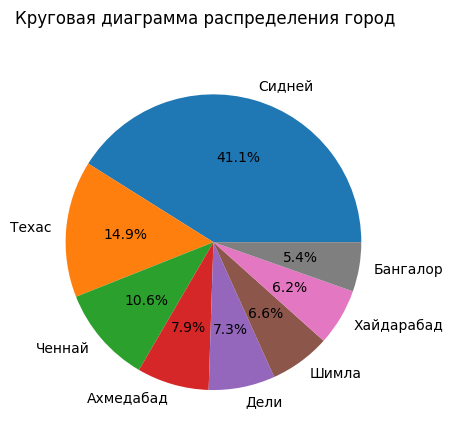

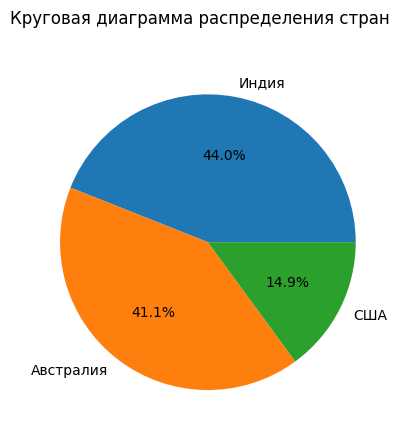

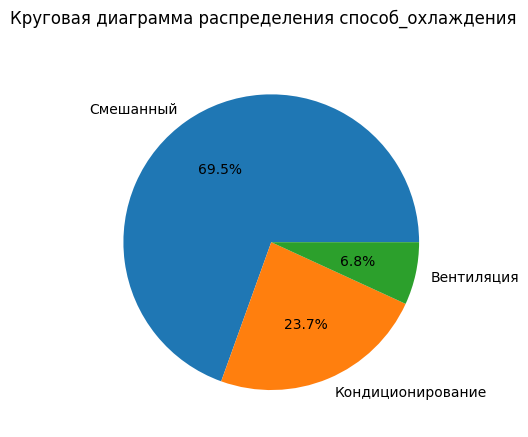

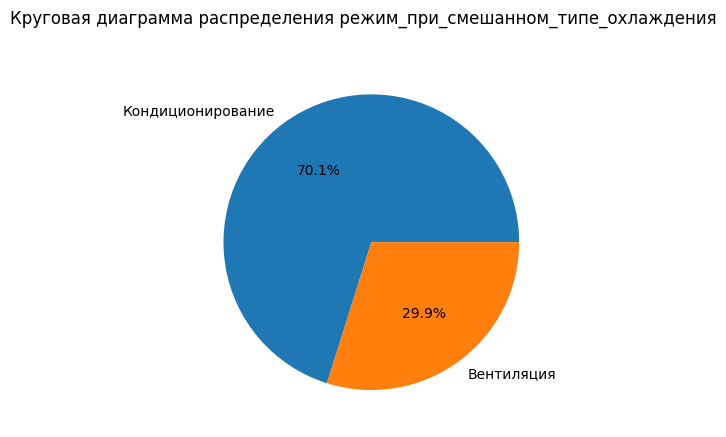

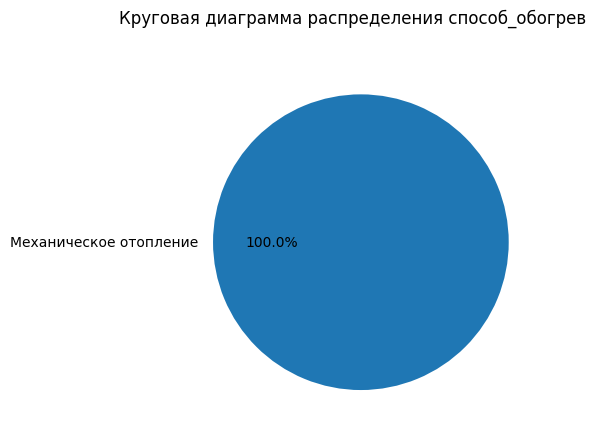

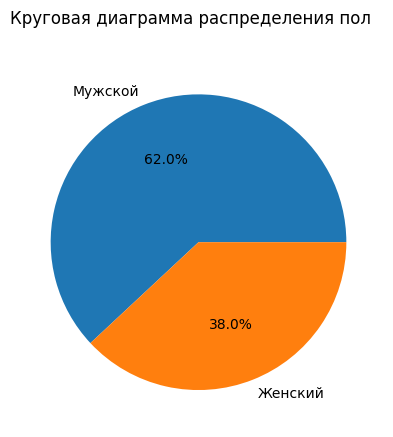

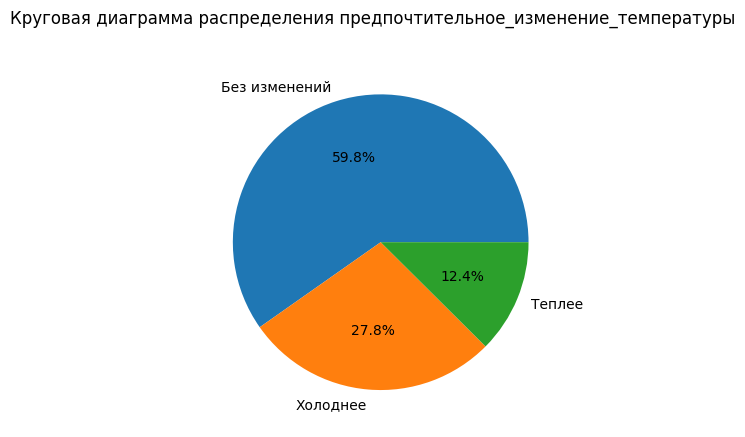

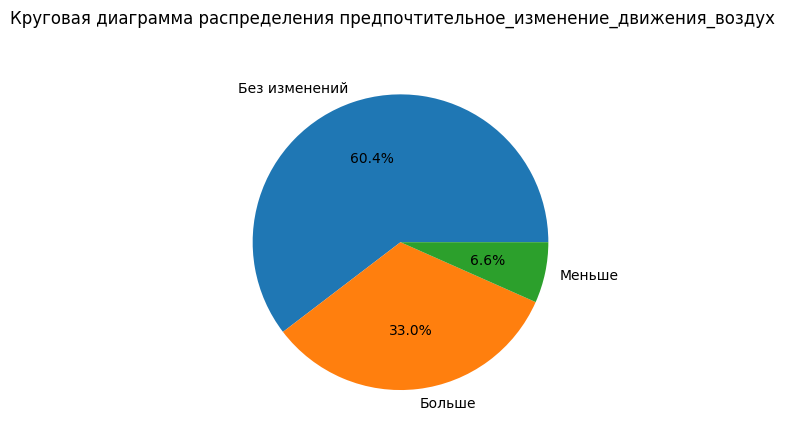

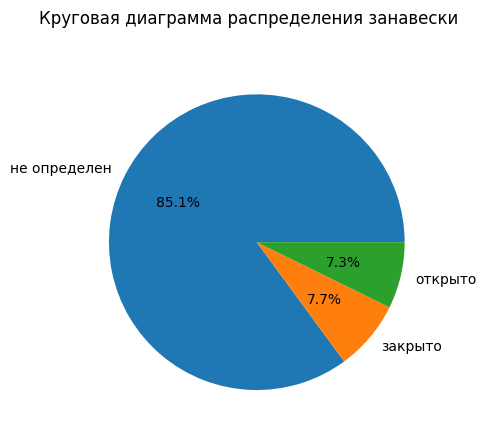

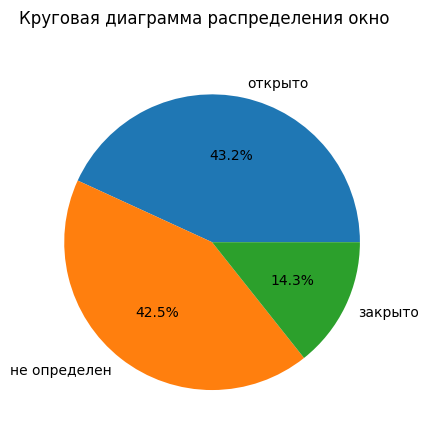

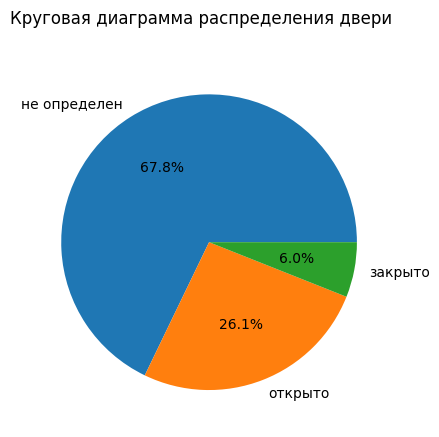

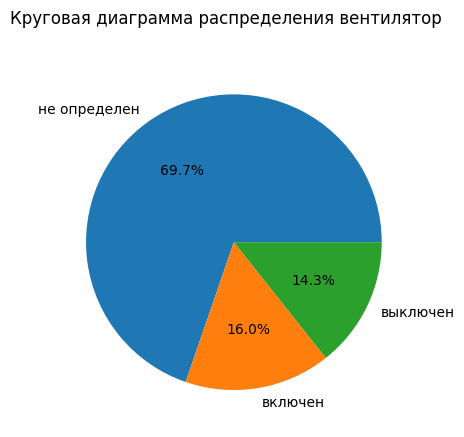

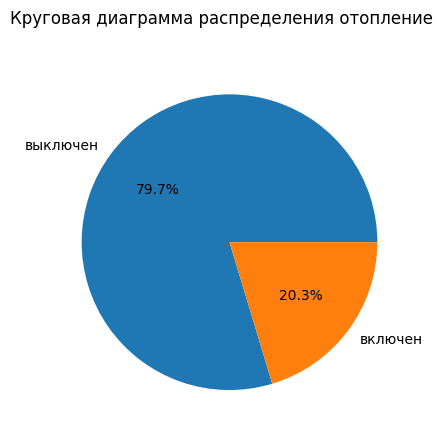

In [72]:
for category in df.select_dtypes(include=['object']).columns:
    data = df[category].value_counts()
    plt.pie(data, labels=data.index, autopct='%1.1f%%')
    title = category.rstrip('_кат')
    plt.suptitle(f'Круговая диаграмма распределения {title}')
    plt.show()

### Расчёты

+ Создадим дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту отдельно: мало (≤1), средне (=2), много (>2).
+ Рассчитаем средний возраст респондентов по полу и стране, чтобы понимать целевую аудиторию.
+ Добавим категориальный столбец, разделив респондентов на три категории по возрасту: до 44 лет - молодой возраст, 45 - 59 лет - средний возраст, 60 лет и больше - пожилой возраст.
+ Рассчитаем среднюю комфортную температуру в зависимости от возрастной категории, чтобы понять потребности клиента.
+ Рассчитаем медианное значение температуры и влажности для каждого типа охлаждения, чтобы посмотреть как тип охлаждения влияет на эти факторы.
+ Добавим столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

In [73]:
def kolvo_complaints_cat(kolvo):
    if kolvo <= 1:
        return 'мало'
    elif kolvo == 2:
        return 'средне'
    return 'много'

In [74]:
# создаем дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту
df['колво_рекламаций_катег'] = df['количество_рекламаций'].apply(kolvo_complaints_cat)
# рассчитываем средний возраст респондентов по полу и стране
average_age_groupby_gender_country = df.groupby(['пол', 'страна'])['возраст'].mean()

In [75]:
average_age_groupby_gender_country

пол      страна   
Женский  Австралия    46.348315
         Индия        36.044776
Мужской  Австралия    42.614679
         Индия        37.275862
Name: возраст, dtype: float64

In [76]:
# рассчитаем медианное значение температуры и влажности для каждого типа охлаждения
median_temp_humidity_for_type_of_cooling = df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

In [77]:
median_temp_humidity_for_type_of_cooling

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.300000,46.30
Кондиционирование,24.277778,42.45
Смешанный,24.600000,56.50


In [78]:
# добавление нового столбца который категоризирует возраст
df['возраст_кат'] = df['возраст'].apply(lambda x: 'молодой_возраст' if x <= 30 else 'средний_возраст' if x <= 59 else 'пожилой_возраст')
# рассчитаем среднюю комфортную температуру в зависимости от возрастной категории
average_comfortable_temp_groupby_agecat = df[df['ощущение_температуры_bool'] == 1].groupby(['возраст_кат'])['температура_воздуха_в_помещении'].mean()

In [79]:
average_comfortable_temp_groupby_agecat

возраст_кат
молодой_возраст    25.063793
пожилой_возраст    24.418695
средний_возраст    24.787645
Name: температура_воздуха_в_помещении, dtype: float64

In [80]:
# 1. Считаем общее количество респондентов по стране и полу
total_counts = df.groupby(['страна', 'пол']).size().rename('общее')

# 2. Считаем количество удовлетворённых респондентов
satisfied_counts = df[df['ощущение_температуры_bool'] == 1].groupby(['страна', 'пол']).size().rename('удовлетворенные')

# 3. Объединяем оба результата
satisfaction_df = pd.concat([total_counts, satisfied_counts], axis=1).fillna(0)

# 4. Считаем процент
satisfaction_df['percent_satisfied'] = (satisfaction_df['удовлетворенные'] / satisfaction_df['общее']).mul(100).round(1)

# 5. Объединяем обратно с исходным df (через merge по стране и полу)
df = df.merge(satisfaction_df['percent_satisfied'], on=['страна', 'пол'])

Создадим новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. Категории назначить самостоятельно.

In [81]:
""" Согласно международным рекомендациям:
ASHRAE (Американское общество инженеров по отоплению, охлаждению и кондиционированию воздуха):
Рекомендуемая относительная влажность в помещениях (включая офисы) — от 30% до 60%.
Комфортный диапазон — 40–60%. """

def cat_hum(rh):
    if rh < 30:
        return 'низкая_влажность'
    elif 30 <= rh <= 60:
        return 'комфортная_влажность'
    return 'высокая_влажность'

# Применим к столбцу 'rh' (относительная влажность)
df['категория_влажности'] = df['rh'].apply(cat_hum)

# Проверим результат
print(df['категория_влажности'].value_counts())

категория_влажности
комфортная_влажность    249
высокая_влажность       149
низкая_влажность         12
Name: count, dtype: int64


Хотелось бы посмотреть оценку комфорта по категории влажности, по странам и сезонам

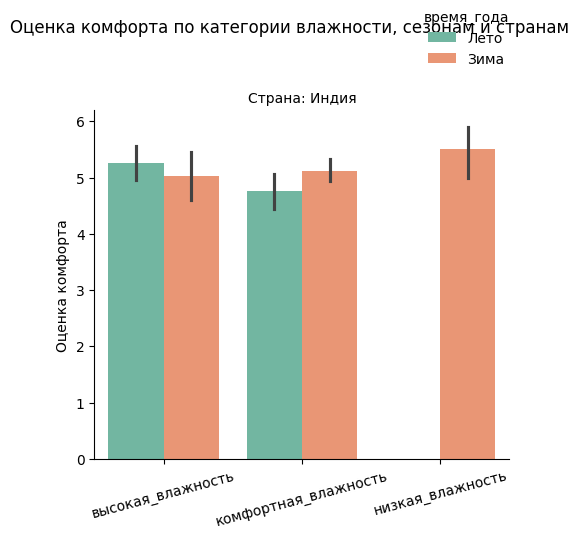

In [82]:
# Фильтруем датафрейм, убираем значения с временами года Весна и Лето, также убираем страну Австралия, так как по ним нет информации
df_filt = df[(df['время_года'] != 'Весна') & (df['время_года'] != 'Осень') & (df['страна'] != 'Австралия')]

# Строим boxplot с фасетами по странам
g = sns.catplot(
    data=df_filt,
    x='категория_влажности',
    y='оценка_комфорта',
    hue='время_года',
    col='страна',
    kind='bar',
    palette='Set2',
    height=5,
    aspect=0.8
)

g.set_axis_labels('', 'Оценка комфорта')
g.set_titles("Страна: {col_name}")
g.fig.suptitle('Оценка комфорта по категории влажности, сезонам и странам', y=1.05)
g.legend.set_bbox_to_anchor((1.05, 1))

# Повернуть подписи на оси X
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=15)
    
plt.tight_layout()
plt.show()

Также хотелось бы посмотреть количество рекламаций (жалоб) по способу охлаждения в разных странах.

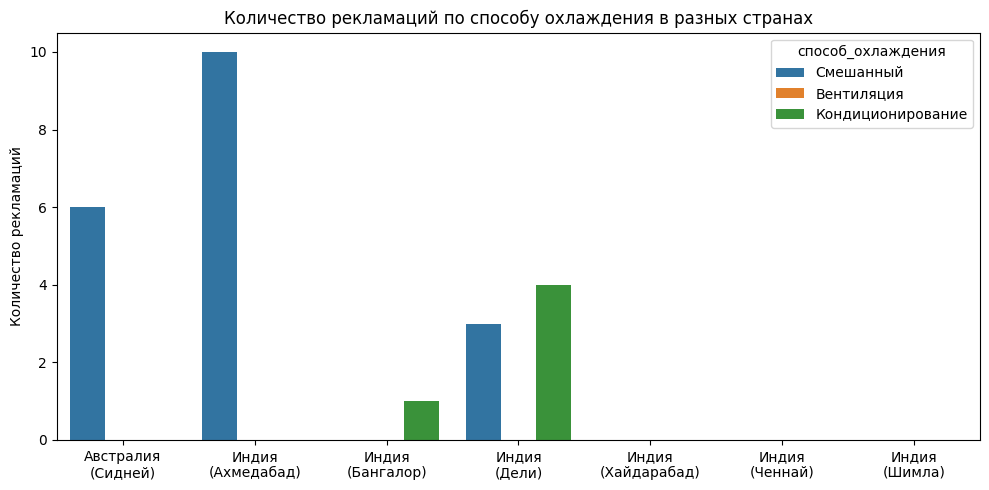

In [83]:
df['страна_город'] = df['страна'] + '\n(' + df['город'] + ')'

# Группировка по стране и способу охлаждения и суммирование жалоб
complaints_by_country_method = df.groupby(['страна_город', 'способ_охлаждения'])['количество_рекламаций'].sum().reset_index()

# Построение графика
plt.figure(figsize=(10, 5))
sns.barplot(
    data=complaints_by_country_method,
    x='страна_город',
    y='количество_рекламаций',
    hue='способ_охлаждения'
)
plt.title("Количество рекламаций по способу охлаждения в разных странах")
plt.ylabel("Количество рекламаций")
plt.xlabel("")
plt.tight_layout()
plt.show()

Составим сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.

In [84]:
index = ['страна', 'пол', 'возраст_кат']
values = ['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']
pd.pivot_table(df, index=index, values=values, aggfunc='mean').round(4)

rh  температура_воздуха_в_помещении
страна    пол     возраст_кат                                              
Австралия Женский молодой_возраст  60.3700                          23.7100
                  пожилой_возраст  44.5500                          24.9000
                  средний_возраст  61.4282                          24.0732
          Мужской молодой_возраст  61.6667                          23.4000
                  пожилой_возраст  64.3667                          24.7333
                  средний_возраст  61.6757                          24.1078
Индия     Женский молодой_возраст  54.5375                          26.3375
                  средний_возраст  48.4431                          26.0549
          Мужской молодой_возраст  53.0694                          24.7722
                  пожилой_возраст  78.8000                          29.3000
                  средний_возраст  49.6778                          26.4657

### Исследование корреляций 

Проведем корреляционный анализ для связи столбцов: количественная-количественная

In [85]:
factors = df.select_dtypes(exclude=[object, bool]).columns[1:]
answer = []
for i in range(len(factors) - 1):
    for j in range(i + 1, len(factors)):
        dt1 = df[factors[i]]
        dt2 = df[factors[j]]
        if shapiro(dt1)[1] >= 0.05 and shapiro(dt2)[1] >= 0.05:
            if float(round(pearsonr(dt1, dt2)[1], 4)) < 0.05:
                answer.append([factors[i], factors[j],
                               float(round(pearsonr(dt1, dt2)[0], 2)),
                               'Пирсон'])
        else:
            if float(round(spearmanr(dt1, dt2)[1], 4)) < 0.05:
                answer.append([factors[i], factors[j],
                               float(round(spearmanr(dt1, dt2)[0], 2)),
                               'Спирмен'])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции', 'метод_корреляции']]
answer.head(20)

,показатель_1,показатель_2,значение_корреляции,метод_корреляции
0,утепление,отопление,0.52,Спирмен
1,температура_воздуха_в_помещении,среднемесячная_температура_на_улице,0.36,Спирмен
2,скорость_воздуха,среднемесячная_температура_на_улице,0.36,Спирмен
3,температура_воздуха_в_помещении,скорость_воздуха,0.28,Спирмен
4,утепление,температура_воздуха_в_помещении,0.20,Спирмен
5,отопление,количество_рекламаций,0.19,Спирмен
6,утепление,количество_рекламаций,0.16,Спирмен
7,возраст,rh,0.15,Спирмен
8,возраст,ощущение_температуры,0.11,Спирмен
9,rh,среднемесячная_температура_на_улице,0.10,Спирмен


Проведем корреляционный анализ для связи столбцов: категориальная-категориальная

Используем метод Kрамера

In [86]:
factors = df.select_dtypes(include=[object, bool]).columns
answer = []
for i in range(len(factors) - 1):
    for j in range(i + 1, len(factors)):
        dt1 = df[factors[i]]
        dt2 = df[factors[j]]
        cramer = my_cramers(dt1, dt2)
        answer.append([factors[i], factors[j], float(round(cramer, 4))])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции']]
answer.head(20)

,показатель_1,показатель_2,значение_корреляции
0,климат,город,1.0000
1,климат,страна,1.0000
2,климат,страна_город,1.0000
3,город,страна,1.0000
4,город,страна_город,1.0000
5,страна,страна_город,1.0000
6,город,отопление_кат,0.6870
7,отопление_кат,страна_город,0.6870
8,климат,отопление_кат,0.6272
9,способ_охлаждения,отопление_кат,0.6259


Нас интересует в какой тип климатического оборудовани вкладывать. Для этого проведем корреляционный анализ для связи столбцов: категориальная-количественная.

Используем Eta для расчета

In [87]:
answer = []
factors = df.select_dtypes(exclude=object).columns
target = 'способ_охлаждения'
for el in factors:
    answer.append([target, el, correlation_ratio(df[target], df[el])])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции']]
answer

,показатель_1,показатель_2,значение_корреляции
0,способ_охлаждения,год,0.457270
1,способ_охлаждения,оценка_комфорта,NaN
2,способ_охлаждения,отопление,0.625913
3,способ_охлаждения,возраст,0.396507
4,способ_охлаждения,утепление,0.304406
5,способ_охлаждения,ощущение_движения_воздуха_bool,0.174322
6,способ_охлаждения,среднемесячная_температура_на_улице,0.169507
7,способ_охлаждения,скорость_воздуха,0.146008
8,способ_охлаждения,ощущение_температуры,0.120311
9,способ_охлаждения,ощущение_температуры_bool,0.085594


Построим матрицу корреляций для наглядности и сделаем выводы, какие факторы коррелируют и что это может нам дать.

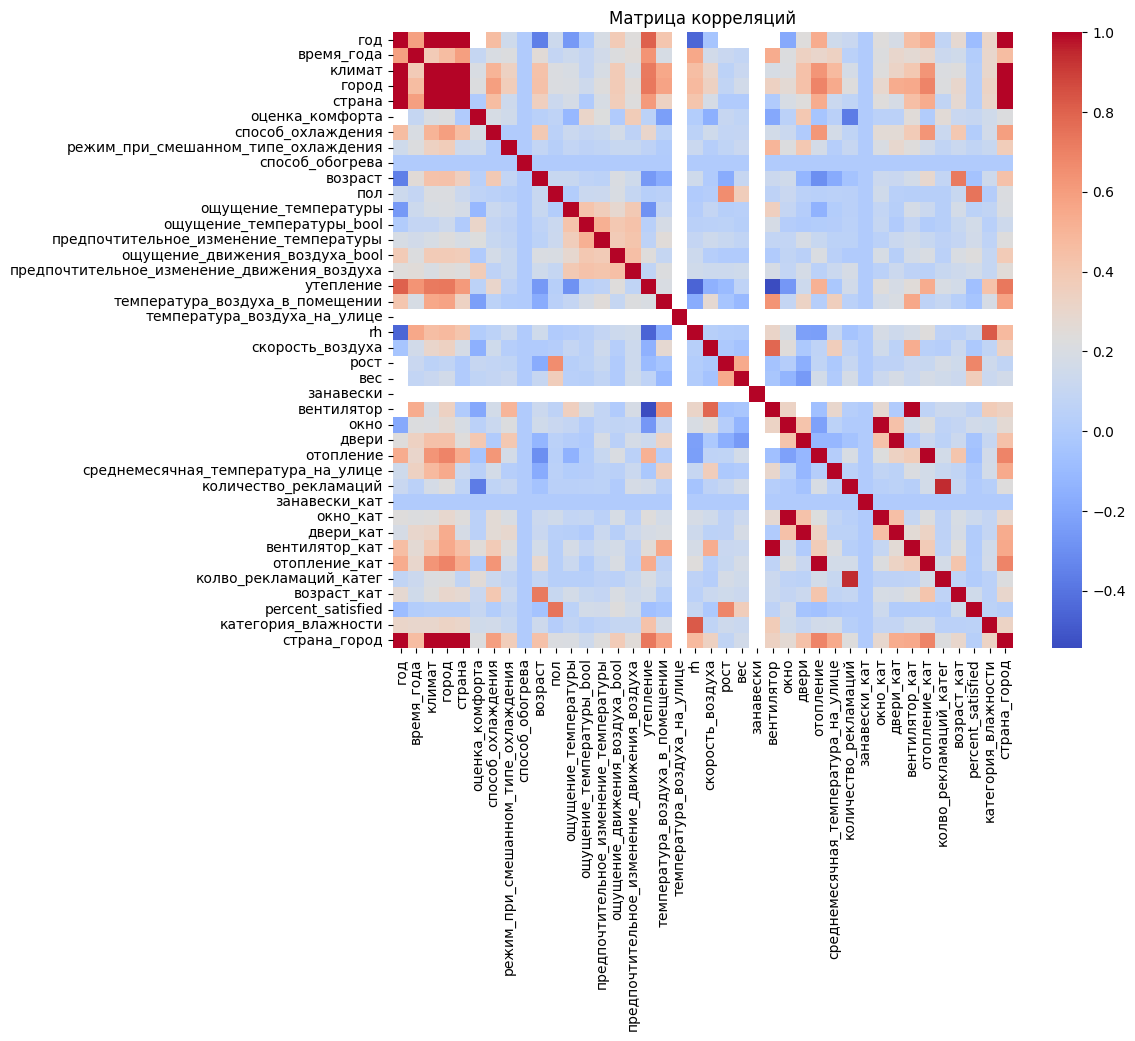

In [88]:
plt.figure(figsize=(10, 8))
corr_df = pd.DataFrame(index=df.columns, columns=df.columns)
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            corr_df.loc[col1, col2] = 1.0
        else:
            if df[col1].dtype in ('int64', 'float64') and df[col2].dtype in ('int64', 'float64'):
                dt1 = df[col1]
                dt2 = df[col2]
                if shapiro(dt1)[1] >= 0.05 and shapiro(dt2)[1] >= 0.05:
                    corr_df.loc[col1, col2] = df[[col1, col2]].corr().iloc[0, 1]
                else:
                    corr_df.loc[col1, col2] = df[[col1, col2]].corr(method='spearman').iloc[0, 1]
            elif df[col1].dtype in ['object', 'bool'] and df[col2].dtype in ['object', 'bool']:
                dt1 = df[col1]
                dt2 = df[col2]
                cramer = my_cramers(dt1, dt2)
                corr_df.loc[col1, col2] = round(cramer, 2)
            else:
                g = df.dropna(subset=[col1, col2])
                if df[col1].dtype in ['object', 'bool']:
                    corr_df.loc[col1, col2] = correlation_ratio(g[col1], g[col2])
                elif df[col2].dtype in ['object', 'bool']:
                    corr_df.loc[col1, col2] = correlation_ratio(g[col2], g[col1])

for col in corr_df.columns:
    corr_df[col] = corr_df[col].astype('float64')
sns.heatmap(corr_df, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()


#### Выводы по корреляциям

+ Факторы, которые коррелируют благодаря географическим особенностям: страна, город, климат, среднемесячная температура, относительная влажность, движение воздуха.
+ Также к этим фактором можно отнести утепление: оно зависит от того, в какой местности ты проживаешь. Наша матрица показывает, что чем хуже оценивают температуру люди, тем больше они "утепляются".
+ На температуру в помещении влияют следующие факторы: климат, город, страна, среднемесячная температура на улице, относительная влажность.
+ На оценку комфорта влияют следующие факторы: изменение движения воздуха и ощущение температуры, а также количество рекламаций. 
+ На факт, какой способ охлаждения выбирают клиенты влияют географические особенности. Еще мы можем увидеть зависимость от того, используют ли пользователи естественную вентиляцию или нет.

Все остальные зависимости не дают четкой картины, поэтому продолжим наше исследование и перейдем к гипотезам.

### Проверка гипотез

#### Гипотезы, выдвинутые руководством

In [89]:
def conclusion(stat, p, method):
    if p < 0.05:
        return f"Метод: {method}, stat: {stat}, p-value: {p}, ✅ Различия в оценке комфорта между группами статистически значимы."
    else:
        return f"Метод: {method}, stat: {stat}, p-value: {p}, 🚫 Различий в комфорте между группами не выявлено."

In [155]:
def mannwhitneyu_for_three_group(groupby, col):
    df2 = df[[groupby, col]].dropna()
    groups = df2.groupby(groupby)[col].apply(list)
    group_names = groups.index.tolist()
    group_data = [groups[name] for name in group_names]

    pvals = []
    comparisons = []
    
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            u_stat, p = mannwhitneyu(group_data[i], group_data[j], alternative='two-sided')
            pvals.append(p)
            comparisons.append(f"{group_names[i]} vs {group_names[j]}")
    
    # Коррекция
    adjusted_pvals = multipletests(pvals, method='bonferroni')[1]
    return adjusted_pvals, comparisons

In [151]:
def calculating_pval(df, columns):
    '''Функция для проверки статистических гипотез 3 и более группах'''
    
    levels = df[columns[0]].unique()
    if len(levels) > 2:
        groups = [group['оценка_комфорта'].dropna().values for name, group in df.groupby('способ_охлаждения')]
        
        if len(set([shapiro(i) for i in groups])) == 1:
            method = 'ANOVA'
            stat, p = f_oneway(*groups)
        else:
            method = 'Краскела–Уоллиса'
            stat, p = kruskal(*groups)
        
        return stat, p, method
    return np.nan, np.nan
    

In [100]:
def numeric_hypothesis_test(sample_1, sample_2):
    '''Функция для проверки статистических гипотез на 2 группах'''
    
    if len(sample_1) < 3 or len(sample_2) < 3:
        return np.nan, np.nan
      
    if shapiro(sample_1)[1] >= 0.05 and shapiro(sample_2)[1] >= 0.05:
      method = 'Стьюдент'
      stat, p = ttest_ind(sample_1, sample_2, equal_var=False)
    else:
      method = 'Манн-Уитни'
      stat, p = mannwhitneyu(sample_1, sample_2, alternative='two-sided')
    
    if p > 0:
        return stat, p, method

In [101]:
# перед проверкой гипотез оценим, влияет ли включенное отопление на оценку комфорта
groups = df[['отопление', 'оценка_комфорта']].dropna()
print(groups.groupby('отопление')['оценка_комфорта'].count())
group1 = groups[groups['отопление'] == 1.0]['оценка_комфорта']
group2 = groups[groups['отопление'] == 0.0]['оценка_комфорта']
print(conclusion(*numeric_hypothesis_test(group1, group2)))

отопление
0.0    83
1.0    98
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, stat: 3886.0, p-value: 0.593919729487365, 🚫 Различий в комфорте между группами не выявлено.


In [102]:
# делаем вывод что отопление не влияет на оценку комфорта

#### Влияет ли способ охлаждения на оценку комфорта? категориальная - количественная

In [103]:
conclusion(*calculating_pval(df=df, columns=['способ_охлаждения', 'оценка_комфорта']))

'Метод: Краскела–Уоллиса, stat: 8.184297163714337, p-value: 0.016703306554929, ✅ Различия в оценке комфорта между группами статистически значимы.'

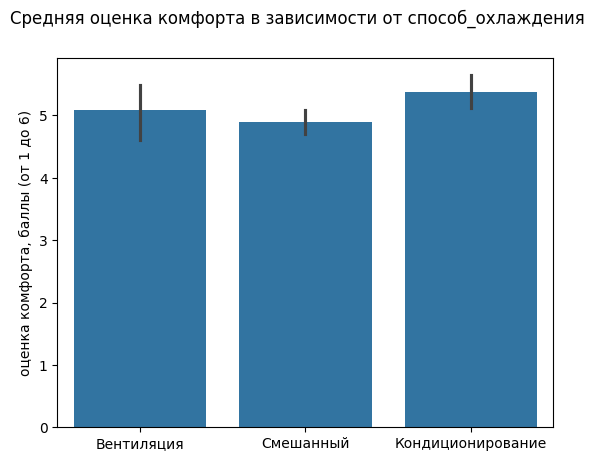

In [112]:
sns.barplot(df_filt, x='способ_охлаждения', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от способ_охлаждения')
plt.show()

#### Влияет ли пол на оценку комфорта? категориальная - количественная

In [124]:
df.groupby('пол')['оценка_комфорта'].count()

пол
Женский     59
Мужской    122
Name: оценка_комфорта, dtype: int64

In [125]:
temp = df[['пол', 'оценка_комфорта']].dropna()
group1 = temp[temp['пол'] == 'Мужской']['оценка_комфорта']
group2 = temp[temp['пол'] == 'Женский']['оценка_комфорта']
print(conclusion(*numeric_hypothesis_test(group1, group2)))

Метод: Манн-Уитни, stat: 4037.0, p-value: 0.16951880319615675, 🚫 Различий в комфорте между группами не выявлено.


In [127]:
# делаем вывод что пол не влияет на оценку комфорта

#### Влияет ли возрастная группа на оценку комфорта? категориальная - количественная

In [128]:
df.groupby('возраст_кат')['оценка_комфорта'].count()

возраст_кат
молодой_возраст     52
пожилой_возраст      1
средний_возраст    128
Name: оценка_комфорта, dtype: int64

In [129]:
# людей входящий в пожилой_возраст всего 1, опустим эту категорию

In [132]:
temp = df[['возраст_кат', 'оценка_комфорта']].dropna()
group1 = temp[temp['возраст_кат'] == 'молодой_возраст']['оценка_комфорта']
group2 = temp[temp['возраст_кат'] == 'средний_возраст']['оценка_комфорта']
conclusion(*numeric_hypothesis_test(group1, group2))

'Метод: Манн-Уитни, stat: 3642.0, p-value: 0.30498798315655296, 🚫 Различий в комфорте между группами не выявлено.'

#### Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта? категориальная - количественная

In [142]:
conclusion(*calculating_pval(df=df, columns=['колво_рекламаций_катег', 'оценка_комфорта']))

'Метод: Краскела–Уоллиса, stat: 8.184297163714337, p-value: 0.016703306554929, ✅ Различия в оценке комфорта между группами статистически значимы.'

In [156]:
adjusted_pvals, comparisons = mannwhitneyu_for_three_group('колво_рекламаций_катег', 'оценка_комфорта')
print("Попарные сравнения с коррекцией Bonferroni:")
for comp, p_adj in zip(comparisons, adjusted_pvals):
    print(f"{comp}: p = {p_adj:.4f}")

Попарные сравнения с коррекцией Bonferroni:
мало vs много: p = 0.6051
мало vs средне: p = 0.0215
много vs средне: p = 0.3197


#### Гипотезы, выдвинутые нашей командой

### Регрессионное моделирование

## Общий вывод